# Importing Libraries

In [3]:
pip install torchvision

  Using cached torch-2.0.0-cp39-cp39-win_amd64.whl (172.3 MB)
  Attempting uninstall: torch
    Found existing installation: torch 1.10.1+cu113
    Uninstalling torch-1.10.1+cu113:
      Successfully uninstalled torch-1.10.1+cu113
Note: you may need to restart the kernel to use updated packages.


ERROR: Could not install packages due to an OSError: [WinError 5] Отказано в доступе: 'C:\\Users\\dany2\\anaconda3\\Lib\\site-packages\\~-rch\\lib\\asmjit.dll'
Consider using the `--user` option or check the permissions.



In [4]:
pip install install opencv-python

Note: you may need to restart the kernel to use updated packages.


In [5]:
pip install imagehash

Note: you may need to restart the kernel to use updated packages.


In [6]:
pip install plotly.express

Note: you may need to restart the kernel to use updated packages.


In [7]:
pip install --upgrade pandas

Note: you may need to restart the kernel to use updated packages.


In [43]:
pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu117

Looking in indexes: https://download.pytorch.org/whl/cu117
Note: you may need to restart the kernel to use updated packages.


In [36]:
pip install nvcc

Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement nvcc (from versions: none)
ERROR: No matching distribution found for nvcc


In [35]:
nvcc --version

NameError: name 'nvcc' is not defined

In [3]:
seed_value= 0

import torch, torchvision
import glob
import os
os.environ['PYTHONHASHSEED']=str(seed_value)
import numpy as np
np.random.seed(seed_value)
import cv2
import random
random.seed(seed_value)
import itertools
import pandas as pd
#from tqdm import tqdm
import urllib
import json
import PIL.Image as Image
import shutil
from os.path import exists
from tqdm.auto import  tqdm
import imagehash
import matplotlib.pyplot as plt
import plotly.express as px
from datetime import datetime

from sklearn.metrics import classification_report, confusion_matrix


main_path = "D:/chemp/Chempionat/input/"
path_groove = main_path + 'Groove'
path_crack = main_path + 'Cracks'

# Load and visualize the dataset

In [4]:
main_df = pd.DataFrame()
main_df['images'] = os.listdir(path_groove) + os.listdir(path_crack)

In [5]:
classes = []
paths = []
for image in main_df['images']:
    class_ = image.split('_')[0]
    if class_ == 'Crack':
        class_+=str('s')
    classes.append(class_)
    paths.append(main_path+"/"+class_+'/'+image)

In [6]:
main_df['classes'] = classes
main_df['path'] = paths

In [7]:
main_df.tail()

,images,classes,path
4530,Crack_995.jpg,Cracks,D:/chemp/Chempionat/input//Cracks/Crack_995.jpg
4531,Crack_996.jpg,Cracks,D:/chemp/Chempionat/input//Cracks/Crack_996.jpg
4532,Crack_997.jpg,Cracks,D:/chemp/Chempionat/input//Cracks/Crack_997.jpg
4533,Crack_998.jpg,Cracks,D:/chemp/Chempionat/input//Cracks/Crack_998.jpg
4534,Crack_999.jpg,Cracks,D:/chemp/Chempionat/input//Cracks/Crack_999.jpg


In [8]:
def plot_species(df,defect_name):
    plt.figure(figsize = (12,12))
    species_df = df[df['classes'] == defect_name].reset_index(drop = True)
    plt.suptitle(defect_name)
    for idx,i in enumerate(np.random.choice(species_df['path'],32)):
        plt.subplot(8,8,idx+1)
        image_path = i
        img = Image.open(image_path)
        img = img.resize((224,224))
        plt.imshow(img)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

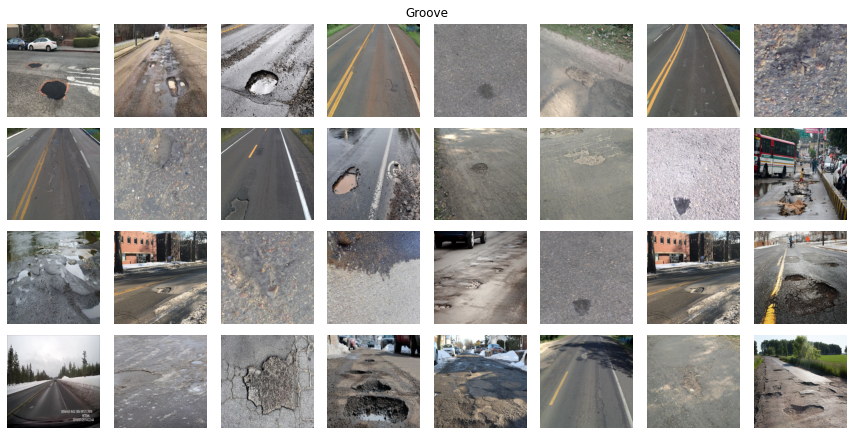

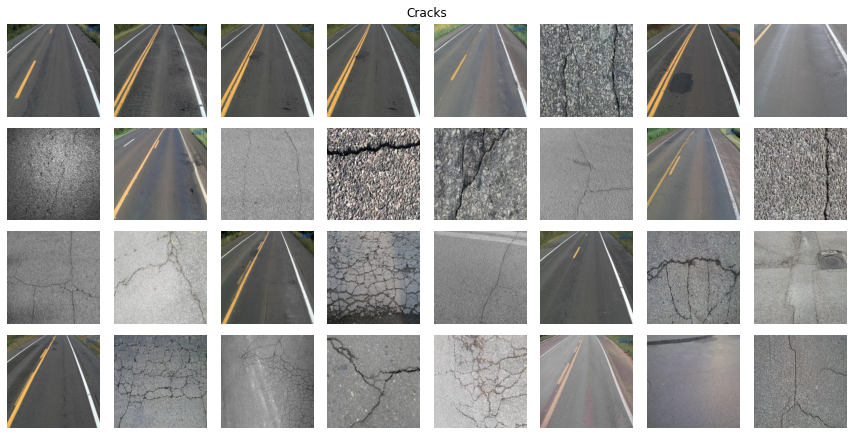

In [9]:
for defect_name in main_df['classes'].unique():
    plot_species(main_df , defect_name)

In [10]:
class_names = sorted(os.listdir(main_path))
class_names

['Cracks', 'Groove']

In [11]:
n_classes = len(class_names)
print(f"Total Number of Classes : {n_classes}")

Total Number of Classes : 2


In [12]:
class_dis = [len(os.listdir(main_path + name)) for name in class_names]
class_dis

[2185, 2350]

In [13]:
fig = px.pie(names=class_names, values=class_dis)
fig.update_layout({'title':{
    'text':'Class Distribution',
    'x':0.5
}})
fig.show()

# Find duplicate images

In [15]:
funcs = [
        imagehash.average_hash,
        imagehash.phash,
        imagehash.dhash,
        imagehash.whash,
    ]
image_ids = []
hashes = []

for i in class_names:
    for path in tqdm(glob.glob(main_path + i + '/' + '*.jpg' )):
        image = Image.open(path)
        image_id = os.path.basename(path)
        image_ids.append(image_id)
        hashes.append(np.array([f(image).hash for f in funcs]).reshape(256))

hashes_all = np.array(hashes)

100%|██████████| 2350/2350 [03:00<00:00, 12.99it/s]


In [16]:
hashes_all = torch.Tensor(hashes_all.astype(int)).cuda()

AssertionError: Torch not compiled with CUDA enabled

In [17]:
sims = np.array([(hashes_all[i] == hashes_all).sum(dim=1).cpu().numpy()/256 for i in range(hashes_all.shape[0])])

TypeError: _sum() got an unexpected keyword argument 'dim'

In [18]:
# we can set different similarity inddex here
indices1 = np.where(sims > 0.9)
indices2 = np.where(indices1[0] != indices1[1])
image_ids1 = [image_ids[i] for i in indices1[0][indices2]]
image_ids2 = [image_ids[i] for i in indices1[1][indices2]]
dups = {tuple(sorted([image_id1,image_id2])):True for image_id1, image_id2 in zip(image_ids1, image_ids2)}

print('found %d duplicates' % len(dups))

NameError: name 'sims' is not defined

In [19]:
duplicate_image_ids = sorted(list(dups))

fig, axs = plt.subplots(4, 2, figsize=(15,15))

for row in range(4):
        for col in range(2):
            img_id = duplicate_image_ids[row][col]
            if img_id.split('_')[0] == 'Crack':  
                img = Image.open(main_path + 'Cracks/' + img_id)
            else:
                img = Image.open(main_path + 'Groove/' + img_id)
            axs[row, col].imshow(img)
            axs[row, col].set_title("file name : "+ img_id)
            axs[row, col].axis('off')

NameError: name 'dups' is not defined

# Remove duplicated images

In [20]:
img_duplicates = []
for image_dup in duplicate_image_ids:
    img_duplicates.append(image_dup[0])

NameError: name 'duplicate_image_ids' is not defined

In [ ]:
imgfiles_crack = []
imgfiles_groove = []
    
    
imgfiles_crack = [ f for f in os.listdir(main_path + 'Cracks/') if os.path.isfile(os.path.join(main_path + 'Cracks/',f)) ]
imgfiles_groove = [ f for f in os.listdir(main_path + 'Groove/') if os.path.isfile(os.path.join(main_path + 'Groove/',f)) ]

imgfiles_crack = sorted(imgfiles_crack)
imgfiles_groove = sorted(imgfiles_groove)

print(len(imgfiles_crack))
print(len(imgfiles_groove))

In [ ]:
#remove the duplicates
imgfiles_crack = [img for img in imgfiles_crack if img not in img_duplicates]
imgfiles_groove = [img for img in imgfiles_groove if img not in img_duplicates]

print(len(imgfiles_crack))
print(len(imgfiles_groove))

In [ ]:
imgfiles = imgfiles_crack + imgfiles_groove
imgfiles = sorted(imgfiles)
random.shuffle(imgfiles)

print(len(imgfiles))

# Split the data

In [ ]:
os.makedirs('./crack+groove/')

os.makedirs('./crack+groove/train/')
os.makedirs('./crack+groove/test/')

os.makedirs('./crack+groove/train/crack')
os.makedirs('./crack+groove/test/crack')

os.makedirs('./crack+groove/train/groove')
os.makedirs('./crack+groove/test/groove')

In [ ]:
test_ratio = 0.20
train_imgs, test_imgs = np.split(np.array(imgfiles), [int(len(imgfiles)* (1 - test_ratio))])
print(train_imgs[0:3])
print(test_imgs[0:3])

In [ ]:
print(len(train_imgs))
print(len(test_imgs))

In [ ]:
train = []
test = []

for name_train in train_imgs:
    if name_train.split('_')[0] == 'Crack':  
        train.append(main_path + 'Cracks/' + name_train)
    else:
        train.append(main_path + 'Groove/' + name_train)
        
        
for name_test in test_imgs:
    if name_test.split('_')[0] == 'Crack':  
        test.append(main_path + 'Cracks/' + name_test)
    else:
        test.append(main_path + 'Groove/' + name_test)
    
    
print(train[0:3])
print(test[0:3])

In [ ]:
import re

for name in train:
    if re.findall(r"[\w']+", name)[3] == 'Cracks':
        shutil.copy(name, './crack+groove/train/crack/')
    else:
        shutil.copy(name, './crack+groove/train/groove/')
        
for name in test:
    if re.findall(r"[\w']+", name)[3] == 'Cracks':
        shutil.copy(name, './crack+groove/test/crack/')
    else:
        shutil.copy(name, './crack+groove/test/groove/')

In [ ]:
# count the contents in each folder
_, _, files = next(os.walk("./crack+groove/train/crack/"))
print(len(files))

_, _, files = next(os.walk("./crack+groove/train/groove/"))
print(len(files))

_, _, files = next(os.walk("./crack+groove/test/crack/"))
print(len(files))

_, _, files = next(os.walk("./crack+groove/test/groove/"))
print(len(files))

# Create the model

In [ ]:
train_path = './crack+groove/train/'
test_path = './crack+groove/test/'

train_names = sorted(os.listdir(train_path))
test_names = sorted(os.listdir(test_path))

assert train_names == test_names

n_classes = len(train_names)
print(f"Total Number of Classes : {n_classes}")

In [ ]:
import tensorflow
from tensorflow import keras

# Data 
from keras.preprocessing.image import ImageDataGenerator

# Model 
from keras.models import Sequential, load_model
from keras.layers import GlobalAvgPool2D as GAP, Dense, Dropout

# Transfer Learning Models 
from tensorflow.keras.applications import InceptionV3, Xception, ResNet152V2, MobileNetV2, InceptionResNetV2

# set random set
tensorflow.random.set_seed(seed_value)

# Callbacks 
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [ ]:
# Initialize Generator
train_gen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True, 
    rotation_range=20,
    validation_split=0.2
)

test_gen = ImageDataGenerator(rescale=1./255)

# Load Data
train_ds = train_gen.flow_from_directory(
    train_path,
    class_mode='binary',
    shuffle=True,
    batch_size=32,
    target_size=(256,256),
    subset="training"
)

val_ds = train_gen.flow_from_directory(
    train_path,
    class_mode='binary',
    shuffle=True,
    batch_size=32,
    target_size=(256,256),
    subset="validation"
)

test_ds = test_gen.flow_from_directory(
    test_path,
    class_mode='binary',
    shuffle=False,
    batch_size=32,
    target_size=(256,256),
)

# Train the models

## 1. ResNet152V2

In [ ]:
# Set Name
name = "ResNet152V2"

# Load Pretrained Model
base_model = ResNet152V2(include_top=False, weights='imagenet', input_shape=(256,256,3))
base_model.trainable = False

# Create Model
resnet = Sequential([
    base_model,
    GAP(),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(n_classes, activation='softmax')
], name=name)

# Compile Model
resnet.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

# Callbacks
cbs = [
#     EarlyStopping(patience=3, restore_best_weights=True),
    ModelCheckpoint(name + ".h5", save_best_only=True)
]

# Train Model
hist_resnet = resnet.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=cbs,
)

In [ ]:
model_resnet = load_model('./ResNet152V2.h5')
model_resnet.summary()

In [ ]:
model_resnet.evaluate(test_ds)

In [ ]:
#Confution Matrix and Classification Report
Y_pred = model_resnet.predict_generator(test_ds, 779 // 32+1)
y_pred = np.argmax(Y_pred, axis=1)

print('Confusion Matrix')
print(confusion_matrix(test_ds.classes, y_pred))

print('\nClassification Report')
target_names = ['crack', 'groove']

print(classification_report(test_ds.classes, y_pred, target_names=target_names))

### The test results for ResNet152V2:
* Accuracy: **95-96%**
* F1 score: **95-96%**
* Precision: **95-96%**
* Recall: **95-96%**

## 2. Xception

In [ ]:
# Set Name
name = "Xception"

# Load Pretrained Model
base_model = Xception(include_top=False, weights='imagenet', input_shape=(256,256,3))
base_model.trainable = False

# Create Model
xception = Sequential([
    base_model,
    GAP(),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(n_classes, activation='softmax')
], name=name)

# Compile Model
xception.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

# Callbacks
cbs = [
#     EarlyStopping(patience=3, restore_best_weights=True),
    ModelCheckpoint(name + ".h5", save_best_only=True)
]

# Train Model
hist_xception = xception.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=cbs
)

In [ ]:
model_xception = load_model('./Xception.h5')
model_xception.summary()

In [ ]:
model_xception.evaluate(test_ds)

In [ ]:
#Confution Matrix and Classification Report
Y_pred = model_xception.predict_generator(test_ds, 779 // 32+1)
y_pred = np.argmax(Y_pred, axis=1)

print('Confusion Matrix')
print(confusion_matrix(test_ds.classes, y_pred))

print('\nClassification Report')
target_names = ['crack', 'groove']

print(classification_report(test_ds.classes, y_pred, target_names=target_names))

### The test results for Xception:
* Accuracy: **93-94%**
* F1 score: **93-94%**
* Precision: **93-94%**
* Recall: **93-94%**

## 3. InceptionV3

In [ ]:
# Set Name
name = "InceptionV3"

# Load Pretrained Model
base_model = InceptionV3(include_top=False, weights='imagenet', input_shape=(256,256,3))
base_model.trainable = False

# Create Model
inception = Sequential([
    base_model,
    GAP(),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(n_classes, activation='softmax')
], name=name)

# Compile Model
inception.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

# Callbacks
cbs = [
#     EarlyStopping(patience=3, restore_best_weights=True),
    ModelCheckpoint(name + ".h5", save_best_only=True)
]

# Train Model
hist_inception = inception.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=cbs
)

In [ ]:
model_inception = load_model('./InceptionV3.h5')
model_inception.summary()

In [ ]:
model_inception.evaluate(test_ds)

In [ ]:
#Confution Matrix and Classification Report
Y_pred = model_inception.predict_generator(test_ds, 779 // 32+1)
y_pred = np.argmax(Y_pred, axis=1)

print('Confusion Matrix')
print(confusion_matrix(test_ds.classes, y_pred))

print('\nClassification Report')
target_names = ['crack', 'groove']

print(classification_report(test_ds.classes, y_pred, target_names=target_names))

### The test results for InceptionV3:
* Accuracy: **94-95%**
* F1 score: **94-95%**
* Precision: **94-95%**
* Recall: **94-95%**

## 4. MobileNetV2 
(for embedded deployment)

In [ ]:
# Set Name
name = "MobileNetV2"

# Load Pretrained Model
base_model = MobileNetV2(include_top=False, weights='imagenet', input_shape=(256,256,3))
base_model.trainable = False

# Create Model
mobilenet = Sequential([
    base_model,
    GAP(),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(n_classes, activation='softmax')
], name=name)

# Compile Model
mobilenet.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

# Callbacks
cbs = [
#     EarlyStopping(patience=3, restore_best_weights=True),
    ModelCheckpoint(name + ".h5", save_best_only=True)
]

# Train Model
hist_mobilenet = mobilenet.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=cbs
)

In [ ]:
model_mobilenet = load_model('./MobileNetV2.h5')
model_mobilenet.summary()

In [ ]:
model_mobilenet.evaluate(test_ds)

In [ ]:
#Confution Matrix and Classification Report
Y_pred = model_mobilenet.predict_generator(test_ds, 779 // 32+1)
y_pred = np.argmax(Y_pred, axis=1)

print('Confusion Matrix')
print(confusion_matrix(test_ds.classes, y_pred))

print('\nClassification Report')
target_names = ['crack', 'groove']

print(classification_report(test_ds.classes, y_pred, target_names=target_names))

### The test results for MobileNetV2:
* Accuracy: **94-95%**
* F1 score: **94-95%**
* Precision: **94-95%**
* Recall: **94-95%**

## 5. InceptionResNetV2

In [ ]:
# Set Name
name = "InceptionResNetV2"

# Load Pretrained Model
base_model = InceptionResNetV2(include_top=False, weights='imagenet', input_shape=(256,256,3))
base_model.trainable = False

# Create Model
inceptionresnet = Sequential([
    base_model,
    GAP(),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(n_classes, activation='softmax')
], name=name)

# Compile Model
inceptionresnet.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

# Callbacks
cbs = [
#     EarlyStopping(patience=3, restore_best_weights=True),
    ModelCheckpoint(name + ".h5", save_best_only=True)
]

# Train Model
hist_inceptionresnet = inceptionresnet.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=cbs
)

In [ ]:
model_inceptionresnet = load_model('./InceptionResNetV2.h5')
model_inceptionresnet.summary()

In [ ]:
model_inceptionresnet.evaluate(test_ds)

In [ ]:
#Confution Matrix and Classification Report
Y_pred = model_inceptionresnet.predict_generator(test_ds, 779 // 32+1)
y_pred = np.argmax(Y_pred, axis=1)

print('Confusion Matrix')
print(confusion_matrix(test_ds.classes, y_pred))

print('\nClassification Report')
target_names = ['crack', 'groove']

print(classification_report(test_ds.classes, y_pred, target_names=target_names))

### The test results for InceptionResNetV2:
* Accuracy: **92-93%**
* F1 score: **92-93%**
* Precision: **92-93%**
* Recall: **92-93%**

# Plot training losses

In [ ]:
# summarize history for loss
plt.plot(hist_resnet.history['loss'])
plt.plot(hist_xception.history['loss'])
plt.plot(hist_inception.history['loss'])
plt.plot(hist_mobilenet.history['loss'])
plt.plot(hist_inceptionresnet.history['loss'])

plt.title('training loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['ResNet152V2', 'Xception', 'InceptionV3', 'MobileNetV2', 'InceptionResNetV2'], loc='upper right')
plt.show()

# Prediction by the best model (ResNet152V2)

In [ ]:
def show_image(image, title=None):
    plt.imshow(image)
    plt.title(title)
    plt.axis('off')

In [ ]:
i=1
plt.figure(figsize=(20,8))
for images, labels in train_ds:
    index = np.random.randint(len(images))
    image, label = images[index], class_names[int(labels[index])]
    pred_label = class_names[np.argmax(model_resnet.predict(image[np.newaxis, ...]))]

    plt.subplot(4,3, i)
    show_image(image, title=f"Orig : {label}, Pred : {pred_label}")
    i+=1
    if i>=13: break

plt.tight_layout()
plt.show()

# Conclusion

After training the **crack+groove** images in five difference models, I obtained these results:
* ResNet152V2: 
    1. Accuracy **95-96%**
    2. F1 score **95-96%**
* Xception:
    1. Accuracy **93-94%**
    2. F1 score **93-94%**
* InceptionV3:
    1. Accuracy **94-95%**
    2. F1 score **94-95%**
* MobileNetV2:
    1. Accuracy **94-95%**
    2. F1 score **94-95%**
* InceptionResNetV2:
    1. Accuracy **92-93%**
    2. F1 score **92-93%**

As we can we, the **highest accuracy and F1 score** is from **ResNet152V2**. Moreover, **ResNet152V2** got the lowest loss among the five models. Therefore, the best model to use in our project is **ResNet152V2**.


# Reference/s
* Face Mask Detection with Empirical Attention: https://www.kaggle.com/code/chandlertimm/face-mask-detection-with-empirical-attention/notebook#Split-the-data-to-train-and-test
* Shoe-Sandal-Boot Classifier: https://www.kaggle.com/code/utkarshsaxenadn/shoe-sandal-boot-classifier-resnet152v2-acc-97/notebook